# HELIUS Code Bridge DA Analysis

## Introduction

For our Code Bridge Jam we chose to analyze the Global Solar Power Tracker from May 2022. This dataset compiles information on global solar farm operational status, MW output, start year, location, and region. We chose this data because it presented an interesting look into the current solar industry and offers a look into what regions may be ripe for future solar farm expansion. 

The dataset supplied contained two sheets, the first an explanation of terms and the second containing the actual data. I chose only to import that usable data and transcribe the explanations within the body of my notebook. The first step in my analysis was to deal with a variety of data irregularities, once those were resolved I was able to examine how locality intersected with solar farm output and quantity. 

The most interesting findings I reached was the contrast between the United States total solar farms and China's. While China had over a third more solar farms, the United States's MegaWatt output was equal to that of China, showing the importance of location in solar energy production. The data also showed that many areas one would expect to be prime climates for solar, like Latin America or Africa, have very small amounts of solar infrastructure. 

My project is structured in an easy to follow manner; it begins with resolving data irregularities, moves to analysis and visualizations, and ends with some csv export code for my project partner. 

## Initialization

In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
df = pd.read_excel('CodeBridge/Global-Solar-Power-Tracker-May-2022.xlsx', sheet_name='Data')

In [4]:
# lets get a look at this data

df.head()

,Country,Project Name,Phase Name,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Status,Start year,Retired year,...,City,"Local area (taluk, county)","Major area (prefecture, district)",State/Province,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
0,Algeria,Adrar Solar Plant,NaN,NaN,NaN,20,MWp/dc,operating,2015.0,NaN,...,Adrar,Adrar District,NaN,Adrar,Africa,L800008,G800008,Wks0068905,NaN,https://gem.wiki/Adrar_Solar_Plant
1,Algeria,Ain Azel solar farm,NaN,محطة توليد الكهرباء بعين زادة,NaN,20,unknown,operating,NaN,NaN,...,Ain Azel,Ain Arnat,NaN,Sétif,Africa,L800010,G800010,Wks0065285,NaN,https://gem.wiki/Ain_Azel_solar_farm
2,Algeria,Ain El Ibel Solar,PV 1,محطة عين الابل للطاقة الشمسية ١,Ain Albel 1 solar plant,20,unknown,operating,2016.0,NaN,...,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800012,Wks0068916,NaN,https://gem.wiki/Ain_El_Ibel_Solar
3,Algeria,Ain El Ibel Solar,PV 2,محطة عين الابل للطاقة الشمسية ٢,Ain Albel 2 solar plant,33,unknown,operating,2017.0,NaN,...,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800013,Wks0073479,NaN,https://gem.wiki/Ain_El_Ibel_Solar
4,Algeria,Ain El Mehl Solar,NaN,محطة عين الملح للطاقة الشمسية,Ain El Melh Solar,20,unknown,operating,2017.0,NaN,...,Ain El Mehl,Aïn El Melh District,NaN,M'Sila,Africa,L800013,G800014,Wks0068915,NaN,https://gem.wiki/Ain_El_Mehl_Solar


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   9331 non-null   object 
 1   Project Name                              9331 non-null   object 
 2   Phase Name                                3981 non-null   object 
 3   Project Name in Local Language / Script   5014 non-null   object 
 4   Other Name(s)                             1600 non-null   object 
 5   Capacity (MW)                             9331 non-null   int64  
 6   Capacity Rating                           9331 non-null   object 
 7   Status                                    9331 non-null   object 
 8   Start year                                6326 non-null   float64
 9   Retired year                              5 non-null      float64
 10  Operator                            

### Initial Data Notes

Right off the bat it is clear that the data is in rough shape. This will require a lot of data prep steps to get my DF in usable shape for effective EDA. 

Steps Include:
- convert all column titles to snake_case
- drop any unnecessary columns (project name in local language, other IDs, wiki_url)
- change column datatypes to correct types 
- fill or drop null values as applicable

The dataset includes the following fields:

- `Country`: Country the project is located in (Unabbreviated)
- `Project Name`: Commonly used name
- `Phase name`: Common name of the project phase.
- `Project Name in Local Language / Script`: Commonly used name in the locally used script
- `Other Name(s)`: Alternative names, including the name in local script
- `Capacity`: Nameplate capacity, or best available data, of the phase in megawatts rounded to whole number
- `Capacity Rating`: The reported capacity rating, unknown selected if not provided
- `Status`: see rows 12-19 above
- `Start year`: Year the project is or is expected to be commissioned
- `Retired year`: Year the plant is taken offline
- `Operator`: The company that operates the project
- `Operator Name in Local Language / Script`: Company name that operates the project in the locally used script
- `Owner`: The company that directly owns the plant; When owned by a special purpose vehicle, the next level of ownership is provided
- `Owner Name in Local Language / Script`: Company name that directly owns the project in the locally used script
- `Latitude`: decimal degrees	Latitude, assumed WGS84 (google maps), of the project (not by unit)
- `Longitude`: decimal degrees	Longitude, assumed WGS84 (google maps), of the project (not by unit)
- `Location accuracy`: approximate, exact	Location is Approximate based on using nearest city or other information in data sources, or Location is Exact when explicitly provided in data source
- `City`: City, town, village, or township (China) where project is located
- `Local Area`: County, taluk, or district (China) where project is located 
- `Major Area`: Prefecture, district, or municipality (China) where project is located
- `State/Province`: Subnational unit where project is located
- `Region`: Region location based on IRENA definition
- `GEM Location ID`: GEM generated ID unique for each project
- `GEM Phase ID`: GEM generated ID unique for each phase
- `Wiki URL`: URL of existing or planned GEM.wiki page

## Preparing the Data & Preliminary EDA

In [6]:
# dropping irrelevent columns

df.drop(
    ['Project Name in Local Language / Script', 'Other Name(s)', 'Operator Name in Local Language / Script', 'Owner Name in Local Language / Script', 'Other IDs (location)', 'Other IDs (unit/phase)', 'Wiki URL'],
    axis = 1, 
    inplace = True
)

In [7]:
# changing column names to snake_case

df.columns = [
    'country', 'project_name', 'phase_name', 'capacity_mw', 'capacity_rating', 'status', 'start_year', 'retired_year', 'operator', 'owner', 'latitude', 'longitude', 'location_accuracy', 'city', 'local_area', 'major_area', 'state_or_province', 'region', 'gem_loc_id', 'gem_phase_id' 
]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            9331 non-null   object 
 1   project_name       9331 non-null   object 
 2   phase_name         3981 non-null   object 
 3   capacity_mw        9331 non-null   int64  
 4   capacity_rating    9331 non-null   object 
 5   status             9331 non-null   object 
 6   start_year         6326 non-null   float64
 7   retired_year       5 non-null      float64
 8   operator           6034 non-null   object 
 9   owner              8491 non-null   object 
 10  latitude           9331 non-null   float64
 11  longitude          9331 non-null   float64
 12  location_accuracy  9331 non-null   object 
 13  city               4909 non-null   object 
 14  local_area         6124 non-null   object 
 15  major_area         5411 non-null   object 
 16  state_or_province  8684 

In [9]:
df.head(5)

,country,project_name,phase_name,capacity_mw,capacity_rating,status,start_year,retired_year,operator,owner,latitude,longitude,location_accuracy,city,local_area,major_area,state_or_province,region,gem_loc_id,gem_phase_id
0,Algeria,Adrar Solar Plant,NaN,20,MWp/dc,operating,2015.0,NaN,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),27.9077,-0.3174,exact,Adrar,Adrar District,NaN,Adrar,Africa,L800008,G800008
1,Algeria,Ain Azel solar farm,NaN,20,unknown,operating,NaN,NaN,NaN,Sonelgaz,36.1611,5.3321,approximate,Ain Azel,Ain Arnat,NaN,Sétif,Africa,L800010,G800010
2,Algeria,Ain El Ibel Solar,PV 1,20,unknown,operating,2016.0,NaN,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.3447,3.1636,exact,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800012
3,Algeria,Ain El Ibel Solar,PV 2,33,unknown,operating,2017.0,NaN,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.3433,3.1696,exact,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800013
4,Algeria,Ain El Mehl Solar,NaN,20,unknown,operating,2017.0,NaN,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.8597,4.2026,exact,Ain El Mehl,Aïn El Melh District,NaN,M'Sila,Africa,L800013,G800014


In [10]:
df['status'].value_counts()

operating       5190
development     2317
announced        654
construction     580
cancelled        434
shelved          155
retired            1
Name: status, dtype: int64

In [11]:
df['region'].value_counts()

Asia                                 4100
North America                        1766
Europe                               1433
South America                        1034
Africa                                436
Oceania                               279
Middle East                           143
Central America and the Caribbean      77
Eurasia                                63
Name: region, dtype: int64

In [12]:
df['location_accuracy'].value_counts()

approximate    5452
exact          3879
Name: location_accuracy, dtype: int64

After fixing the column names I will change the datatypes of `status`, `region`, and `location accuracy` to the `category` type to reduce the size of the dataframe

In [13]:
df['status'] = df['status'].astype('category')

In [14]:
df['region'] = df['region'].astype('category')

In [15]:
df['location_accuracy'] = df['location_accuracy'].astype('category')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            9331 non-null   object  
 1   project_name       9331 non-null   object  
 2   phase_name         3981 non-null   object  
 3   capacity_mw        9331 non-null   int64   
 4   capacity_rating    9331 non-null   object  
 5   status             9331 non-null   category
 6   start_year         6326 non-null   float64 
 7   retired_year       5 non-null      float64 
 8   operator           6034 non-null   object  
 9   owner              8491 non-null   object  
 10  latitude           9331 non-null   float64 
 11  longitude          9331 non-null   float64 
 12  location_accuracy  9331 non-null   category
 13  city               4909 non-null   object  
 14  local_area         6124 non-null   object  
 15  major_area         5411 non-null   object  
 16  state_

#### Notes

Now that the datatypes that I can easily fix are finished I will need to fill or remove the null values, of which there are a great deal. This will require me to assess whether the missing data will can be filled based on available information or if it will remain a mystery, and if so how much that missing data will impact my analysis. 

In [17]:
df['phase_name'].value_counts()

1                 1886
2                  867
3                  311
4                  147
5                  100
                  ... 
Calamocha            1
Escucha              1
Sirius               1
Castiblanco          1
Young Facility       1
Name: phase_name, Length: 251, dtype: int64

In [18]:
df['start_year'].value_counts()

2016.0    901
2017.0    826
2022.0    571
2015.0    534
2018.0    523
2019.0    520
2021.0    487
2020.0    455
2014.0    401
2023.0    314
2013.0    295
2012.0    137
2024.0    134
2011.0     72
2025.0     52
2026.0     30
2010.0     26
2027.0     13
2008.0     13
2009.0     12
2007.0      4
2028.0      2
2030.0      2
2029.0      1
2038.0      1
Name: start_year, dtype: int64

In [19]:
mean_start_year = df.pivot_table(
    index = ['country', 'status'],
    values = 'start_year'
)

mean_start_year

start_year
country        status                  
Afghanistan    announced    2025.000000
               development  2022.500000
Albania        development  2022.500000
Algeria        announced    2023.000000
               operating    2016.222222
...                                 ...
Vietnam        development  2022.900000
               operating    2019.420635
Western Sahara operating    2018.000000
Zambia         operating    2019.000000
Zimbabwe       operating    2019.000000

[240 rows x 1 columns]

In [20]:
median_start_year = df.pivot_table(
    index = ['country', 'status'],
    values = 'start_year',
    aggfunc = 'median'
)

median_start_year

start_year
country        status                 
Afghanistan    announced        2025.0
               development      2022.0
Albania        development      2022.5
Algeria        announced        2023.0
               operating        2016.0
...                                ...
Vietnam        development      2022.5
               operating        2019.0
Western Sahara operating        2018.0
Zambia         operating        2019.0
Zimbabwe       operating        2019.0

[240 rows x 1 columns]

I will fill the null values in `start_year` using the median start year based off `country` and `status`. This gives me solid estimates given establised timelines in the various localities.

In [21]:
# creating a loop to fill the null values in `start_year`

def avg_start_year(row):
    
    country = row['country']
    status = row['status']
    try:
        avg_start_year = df[(df['status'] == status) & (df['country'] == country) & ~(df['start_year'].isna())]['start_year'].median()
        return avg_start_year
    except:
        return

In [22]:
df.loc[df['start_year'].isna(), 'start_year'] = df[df['start_year'].isna()].apply(avg_start_year, axis = 1)

In [23]:
df['retired_year'].value_counts()

2058.0    3
2047.0    1
2051.0    1
Name: retired_year, dtype: int64

#### Notes

We can see here that the 5 solar farms with data in the `retired_year` column are not actully currently retired, they just have projected end dates. The closest of these dates in 2047, 25 years from now. Because of this I will remove this column from my dataframe. 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            9331 non-null   object  
 1   project_name       9331 non-null   object  
 2   phase_name         3981 non-null   object  
 3   capacity_mw        9331 non-null   int64   
 4   capacity_rating    9331 non-null   object  
 5   status             9331 non-null   category
 6   start_year         8452 non-null   float64 
 7   retired_year       5 non-null      float64 
 8   operator           6034 non-null   object  
 9   owner              8491 non-null   object  
 10  latitude           9331 non-null   float64 
 11  longitude          9331 non-null   float64 
 12  location_accuracy  9331 non-null   category
 13  city               4909 non-null   object  
 14  local_area         6124 non-null   object  
 15  major_area         5411 non-null   object  
 16  state_

The `avg_start_year` function filled the majority of null values in `start_year`. I will drop the remaining rows with null values as these cannot be filled with available data. 

In [25]:
df.drop(['retired_year'] ,axis = 1, inplace = True)

In [26]:
df.dropna(inplace=True, subset=['start_year'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8452 entries, 0 to 9330
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            8452 non-null   object  
 1   project_name       8452 non-null   object  
 2   phase_name         3769 non-null   object  
 3   capacity_mw        8452 non-null   int64   
 4   capacity_rating    8452 non-null   object  
 5   status             8452 non-null   category
 6   start_year         8452 non-null   float64 
 7   operator           5820 non-null   object  
 8   owner              7754 non-null   object  
 9   latitude           8452 non-null   float64 
 10  longitude          8452 non-null   float64 
 11  location_accuracy  8452 non-null   category
 12  city               4516 non-null   object  
 13  local_area         5749 non-null   object  
 14  major_area         5127 non-null   object  
 15  state_or_province  7989 non-null   object  
 16  region

In [28]:
df.groupby(['phase_name','status', 'operator']).head(5)

,country,project_name,phase_name,capacity_mw,capacity_rating,status,start_year,operator,owner,latitude,longitude,location_accuracy,city,local_area,major_area,state_or_province,region,gem_loc_id,gem_phase_id
0,Algeria,Adrar Solar Plant,NaN,20,MWp/dc,operating,2015.0,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),27.9077,-0.3174,exact,Adrar,Adrar District,NaN,Adrar,Africa,L800008,G800008
1,Algeria,Ain Azel solar farm,NaN,20,unknown,operating,2016.0,NaN,Sonelgaz,36.1611,5.3321,approximate,Ain Azel,Ain Arnat,NaN,Sétif,Africa,L800010,G800010
2,Algeria,Ain El Ibel Solar,PV 1,20,unknown,operating,2016.0,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.3447,3.1636,exact,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800012
3,Algeria,Ain El Ibel Solar,PV 2,33,unknown,operating,2017.0,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.3433,3.1696,exact,Ain El Ibel,Aïn El Ibel District,NaN,Djelfa,Africa,L800012,G800013
4,Algeria,Ain El Mehl Solar,NaN,20,unknown,operating,2017.0,Shariket Kahraba wa Taket Moutadjadida (SKTM),Shariket Kahraba wa Taket Moutadjadida (SKTM),34.8597,4.2026,exact,Ain El Mehl,Aïn El Melh District,NaN,M'Sila,Africa,L800013,G800014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9257,Colombia,Sabana De Torres solar farm,2,35,MWp/dc,development,2020.0,Colombia Solar Corporation International,NaN,7.3939,-73.4999,approximate,NaN,NaN,Sabana de Torres,Santander,South America,L807070,G808195
9266,Colombia,San Juan Solar Plant,1,100,unknown,development,2022.0,Colombia Solar Corporation International,Colombia Solar Corporation International,10.8148,-73.0845,approximate,NaN,NaN,San Juan del Cesar,La Guajira,South America,L807069,G808193
9267,Colombia,San Juan Solar Plant,2,100,unknown,development,2022.0,Colombia Solar Corporation International,Colombia Solar Corporation International,10.8148,-73.0845,approximate,NaN,NaN,San Juan del Cesar,La Guajira,South America,L807069,G808194
9275,Colombia,Summa Solar Project,2,200,MWp/dc,development,2023.0,Proelectrica,NaN,8.7974,-75.4522,approximate,NaN,NaN,Sahagún,Córdoba,South America,L807388,G808842


#### Notes

The `phase_name` column is both missing a great deal of data and appears to contain site-specific data. This means that the Null values cannot be filled with available data. From the chunk above we can see that each unique operator uses their own terminology, thus making it irrelevent to more holisitc analysis, particularly given that the `status` column has essentially the same information but applied consistently. For this reason I am electing to drop the `phase_name` column.

In [29]:
df.drop(['phase_name'], axis = 1, inplace = True)

#### Notes

The next step is to address the Null values in `city`, `local_area`, `major_area`, and `state_or_province`. One option would be to 'waterfall' the data from `region` to `state_or_province` to `major_area` etc. This would fill the columns but because it is not accurate to the granular nature of the smaller localities it may create artificually inflated values. 

For this reason I will fill the null values with 'unknown'. Becuase I will primarily be focusing on `region` and `state_or_province` this should mitigate any analyitical problems. 

In [30]:
df[['city', 'local_area', 'major_area', 'state_or_province']] = df[['city', 'local_area', 'major_area', 'state_or_province']].fillna('unknown')

In [31]:
df['start_year'] = df['start_year'].astype(int)
df['start_year']

0       2015
1       2016
2       2016
3       2017
4       2017
        ... 
9326    2016
9327    2017
9328    2016
9329    2015
9330    2016
Name: start_year, Length: 8452, dtype: int64

In [32]:
df['operator'] = df['operator'].fillna(df['owner'])

In [33]:
df['owner'] = df['owner'].fillna(df['operator'])

In [34]:
df[['owner', 'operator']] = df[['owner', 'operator']].fillna('unknown')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8452 entries, 0 to 9330
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            8452 non-null   object  
 1   project_name       8452 non-null   object  
 2   capacity_mw        8452 non-null   int64   
 3   capacity_rating    8452 non-null   object  
 4   status             8452 non-null   category
 5   start_year         8452 non-null   int64   
 6   operator           8452 non-null   object  
 7   owner              8452 non-null   object  
 8   latitude           8452 non-null   float64 
 9   longitude          8452 non-null   float64 
 10  location_accuracy  8452 non-null   category
 11  city               8452 non-null   object  
 12  local_area         8452 non-null   object  
 13  major_area         8452 non-null   object  
 14  state_or_province  8452 non-null   object  
 15  region             8452 non-null   category
 16  gem_lo

### Data Prep & Preliminary EDA Conclusion

I have now reached the point where my null values are either removed or filled, all datatypes are corrected and columns names are changed to snake_case. From here I can begin to generate my visualizations of my data in the exploratory data analysis section. 

I will be focusing my investigation into prime locations for solar, both from a longitudianl/latitudinal perspective and region-based persepctive. I am also interested in the increase of solar farms over time, including those still in development. 

## Exploratory Data Analysis & Visualizations

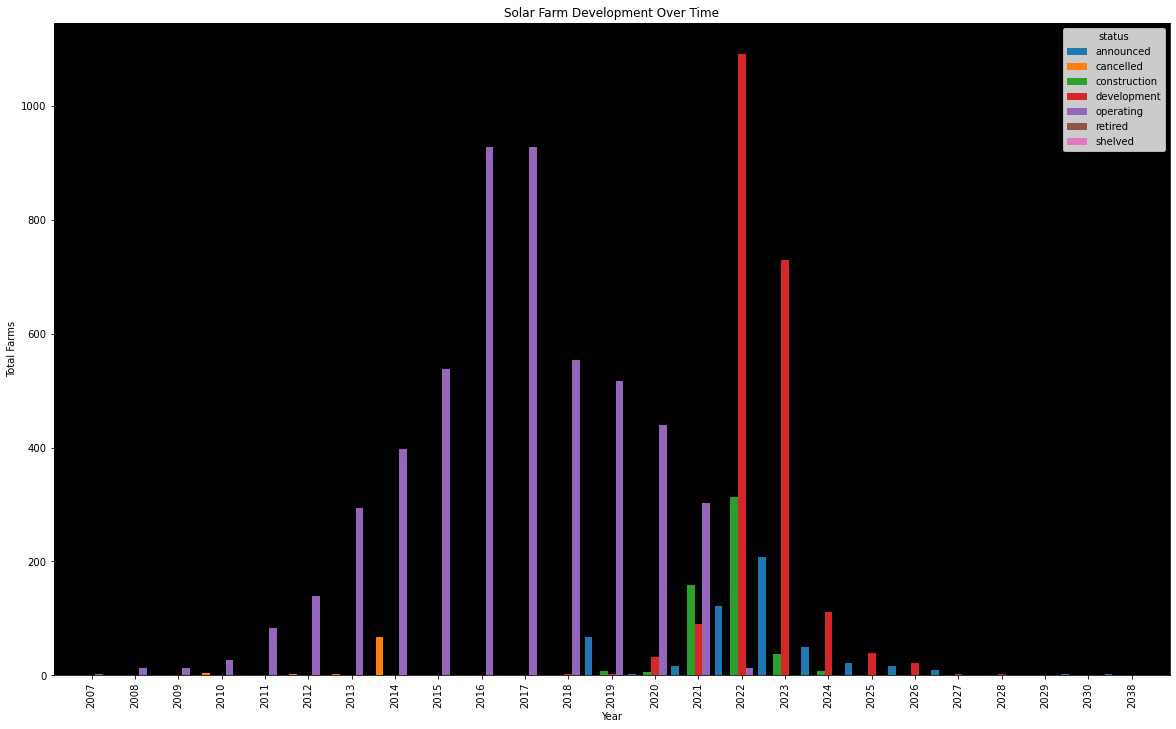

In [36]:
# solar farms over time

solar_farm_time_pivot = df.pivot_table(
    index = 'start_year',
    columns = 'status',
    values = 'project_name',
    aggfunc = 'count'
)

fig1 = solar_farm_time_pivot.plot(kind = 'bar', figsize = (20,12), grid = False, width = 1.25)
fig1.patch.set_facecolor('black')
fig1.patch.set_alpha(1.0)
plt.title('Solar Farm Development Over Time')
plt.xlabel('Year', color = 'black')
plt.ylabel('Total Farms', color = 'black')

ax = plt.subplot(111)
ax.patch.set_facecolor('black')
ax.patch.set_alpha(1.0)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')

Here we can see the promising future of global solar farms. Solar farms reaching operation had a sharp growth period between 2013 and 2017. The following several years showed more solar farms reaching operational status, but did represent a drop in quantity. Beginning in 2020 however we see a huge spike in solar farms in development, peaking in 2022. As our data looks to the future we see even more solar farms announced and in development, showing that solar is a massive growth industry that can be expected to produce a significant return on investment. 


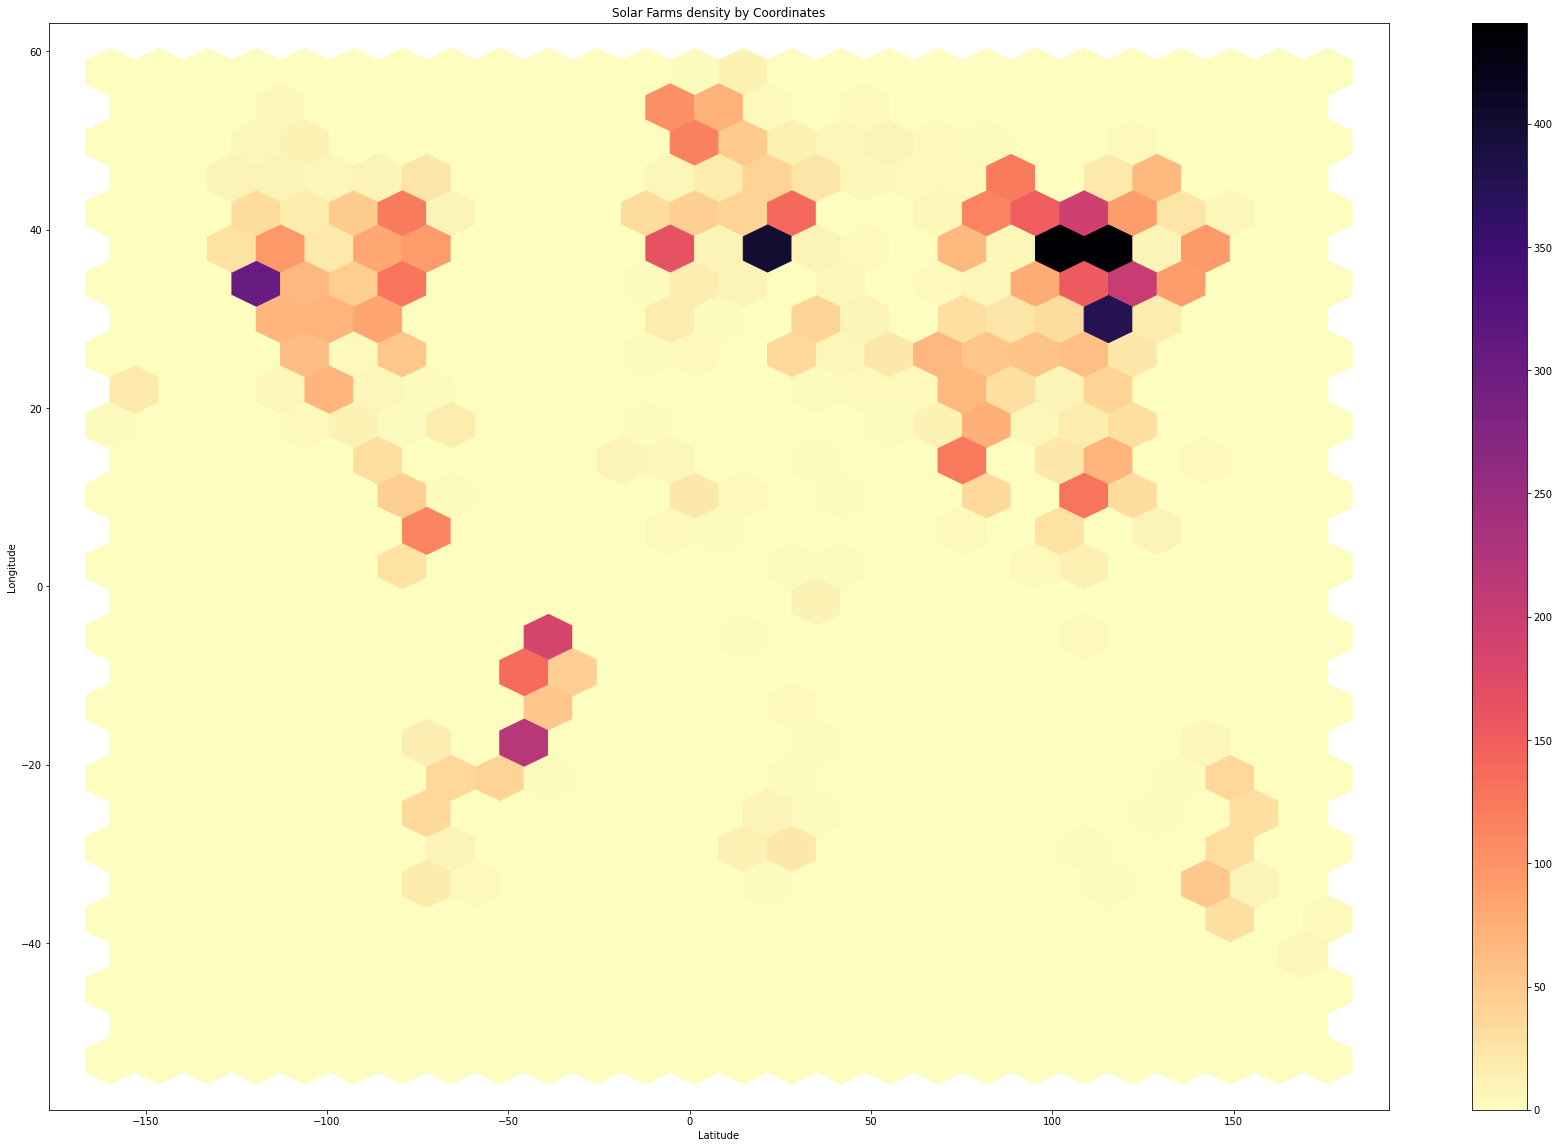

In [37]:
df.plot(
    x='longitude', 
    y='latitude', 
    kind='hexbin', 
    figsize = (30,20), 
    cmap = 'magma_r', 
    gridsize=25, 
    mincnt = 0, 
    sharex=False
)
plt.title('Solar Farms density by Coordinates', color = 'black')
plt.xlabel('Latitude', color = 'black')
plt.ylabel('Longitude', color = 'black')

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')


The graph below shows us the density of solar farms geographically based on longitude & latitude. Interestingly, by using this approach the data formed into a pseudo-world map, offering a clear vision of global solar. We can see here that solar is most highly concentrated in Asia, Europe, and the Western United States. Developing nations, many which would serve as great locations for solar energy production, are underutilized. With effective investments into the necessary infrastructure solar farms could help these underserved communities immensely. 

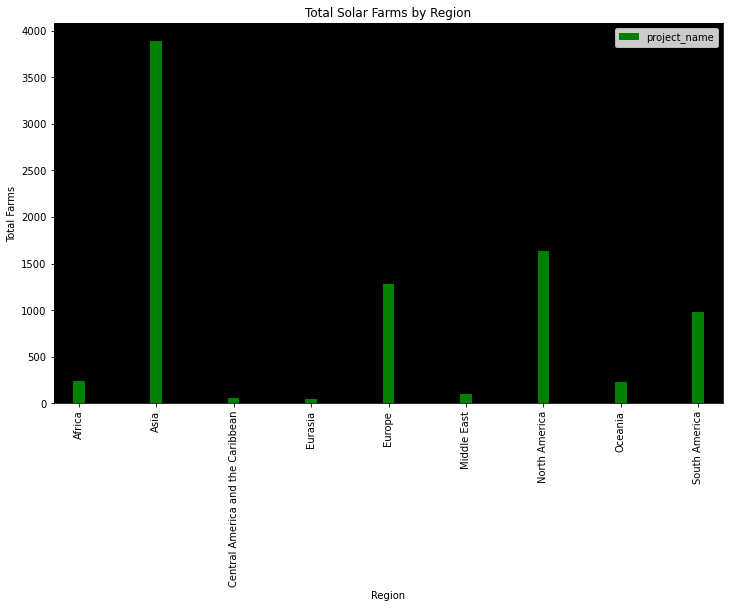

In [38]:
solar_region = df.pivot_table(
    index = 'region',
    values = 'project_name',
    aggfunc = 'count'
)

fig3 = solar_region.plot(kind = 'bar', figsize = (12,7), color = 'green', width = .15)
fig3.patch.set_facecolor('black')
fig3.patch.set_alpha(1.0)
plt.title('Total Solar Farms by Region')
plt.xlabel('Region', color = 'black')
plt.ylabel('Total Farms', color = 'black')

ax = plt.subplot(111)
ax.patch.set_facecolor('black')
ax.patch.set_alpha(1.0)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')

This bar chart tells an explicit story into which nations have best invested in solar energy. Leading the pack at nearly 4000 total solar farms is Asia. Following behind by a wide margin is North America, Europe, and South America. Developing nations in Africa, Central America and the Caribbean lag behind dramatically, and represent huge potential growth markets for solar farm investment. The Middle East also presents a potential market. Low solar power investment is to be expected given the area’s reliance on fossil fuels, but given the climate of the area is a prime location for solar farms. 

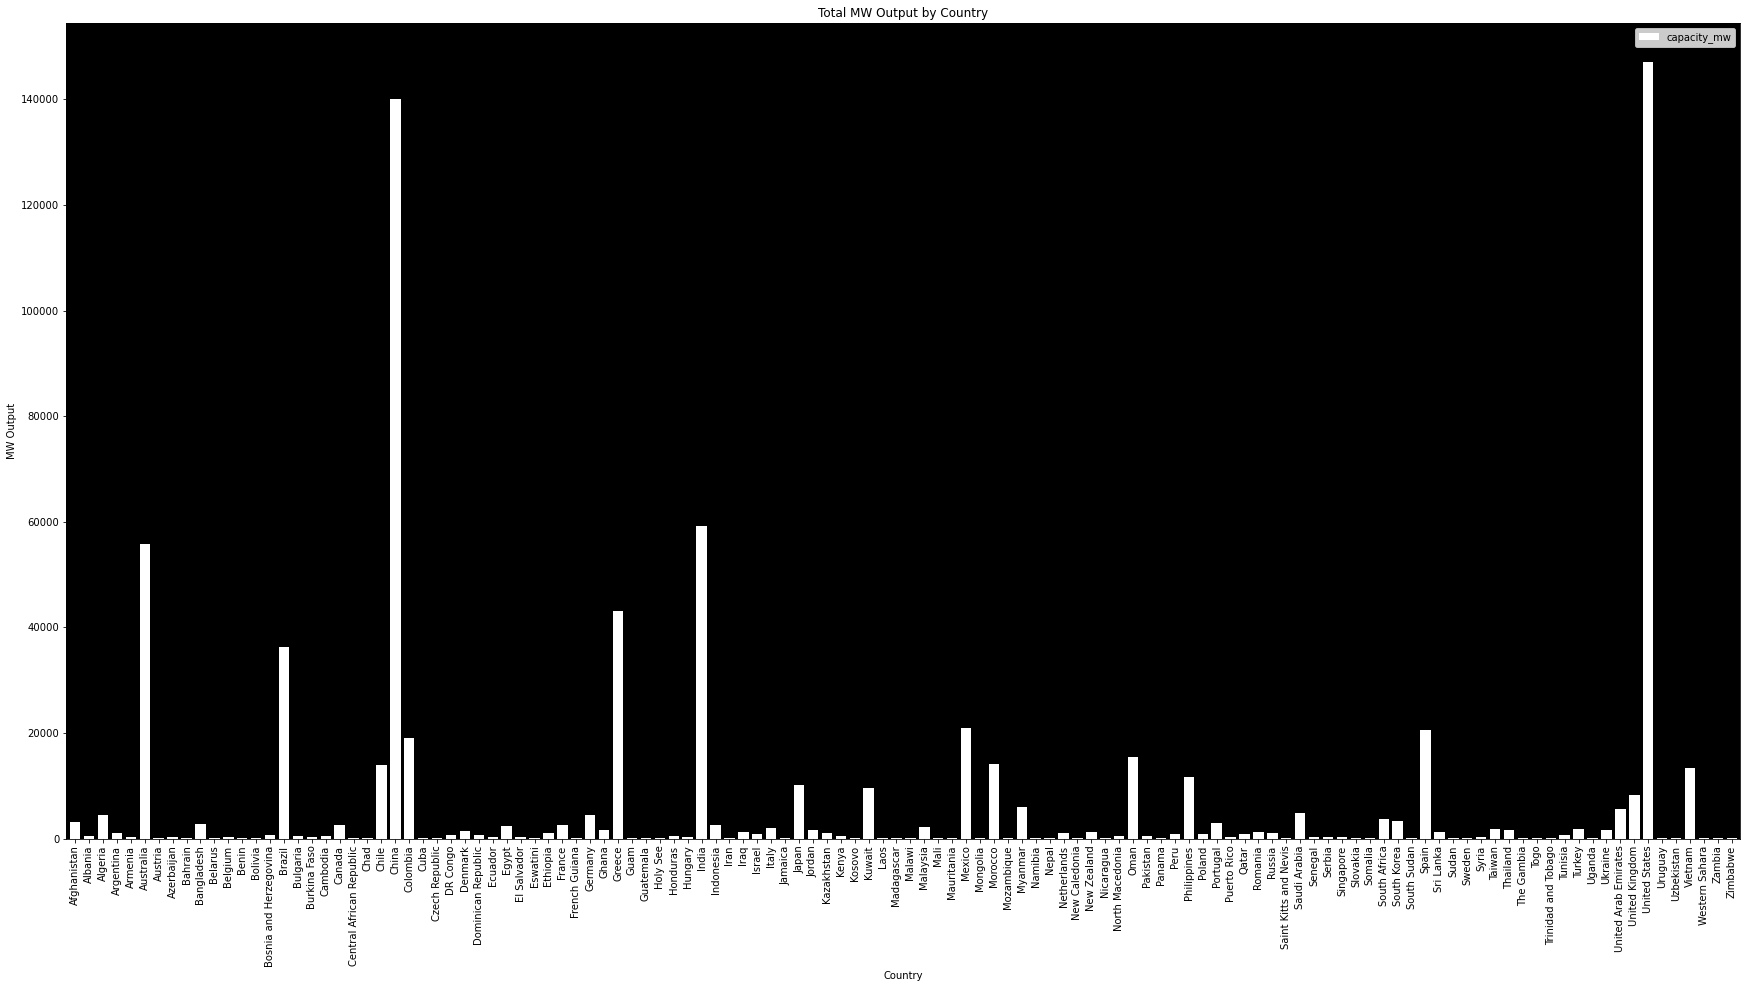

In [39]:
output_pivot = df.pivot_table(
    index = 'country',
    values = 'capacity_mw',
    aggfunc = 'sum'
)

fig4 = output_pivot.plot(kind = 'bar', figsize = (30,15), color = 'white', width = .75)
fig4.patch.set_facecolor('black')
fig4.patch.set_alpha(1.0)
plt.title('Total MW Output by Country')
plt.xlabel('Country', color = 'black')
plt.ylabel('MW Output', color = 'black')

ax = plt.subplot(111)
ax.patch.set_facecolor('black')
ax.patch.set_alpha(1.0)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.title.set_color('black')

The story told by this graph is illuminating given the context of the previous three graphs. Here we can truly see prime areas for solar farms based on their MegaWatt outputs. North American and China have the same MW output despite the Asia region having double the solar farms. Even with the high output of India we can see that North America produces more energy per solar farm than China. Additionally, despite the small number of solar farms the Oceania region contains, Australia’s MW output rivals that of India. This data can help us identify both areas that are prime for solar farm investment and will produce the greatest return on that investment. 


### Exporting Files

Now that my data visualizations and analysis are completed I need to export two datasets for my partner to imput into our landing page.

In [40]:
output_pivot_2 = df.pivot_table(
    index = 'country',
    values = 'capacity_mw',
    aggfunc = 'sum'
).reset_index()

output_pivot_2.head()

,country,capacity_mw
0,Afghanistan,3135
1,Albania,390
2,Algeria,4455
3,Argentina,1001
4,Armenia,200


In [41]:
output_pivot_2.to_csv(index = False)
'ncountry\ncapacity_mw'
compression_opts = dict(method='zip', archive_name='country_output.csv')  

output_pivot_2.to_csv('country_output.zip', index=False, compression=compression_opts)  

In [42]:
from pathlib import Path  
filepath = Path('CodeBridge/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
output_pivot.to_csv(filepath) 

In [43]:
farms_by_country = df.pivot_table(
    index = 'country',
    values = 'project_name',
    aggfunc = 'count'
).reset_index()

farms_by_country.head()

,country,project_name
0,Afghanistan,5
1,Albania,5
2,Algeria,22
3,Argentina,13
4,Armenia,1


In [44]:
farms_by_country.to_csv(index = False)
'ncountry\nproject_name'
compression_opts = dict(method='zip', archive_name='farms_by_country.csv')  

farms_by_country.to_csv('farms_by_country.zip', index=False, compression=compression_opts)  

from pathlib import Path  
filepath = Path('CodeBridge/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
output_pivot.to_csv(filepath) 

## Conclusion 

The analysis conducted in this project represents only the entry point into the potential for global solar expansion. We can see from the above data that nations in the Global South are severely underdeveloped for solar energy production and may be prime areas for investment in solar infrastructure. Using Australia as a climate example we can see that even with relatively few solar farms the energy production in these areas is dramatically higher than that of colder climates. 